In [1]:
import comp_viz
networks = comp_viz.utils.ObjectDetection.get_networks()
networks.pop(1)
print(networks)

['yolo3_mobilenet1.0_coco', 'yolo3_darknet53_coco', 'center_net_resnet101_v1b_dcnv2_coco', 'faster_rcnn_fpn_resnet50_v1b_coco', 'faster_rcnn_fpn_syncbn_resnest269_coco']


In [2]:
dataset = { 'person': {"images": 'datasets/person_0/images/', "labels": "datasets/person_0/labelTxt/"} }

In [10]:
import os
for network in networks:
  try:
    os.mkdir(f"tests/{network}")
  except:
    pass

In [9]:
for network in networks:
  try:
    os.mkdir(f"inference/{network}")
  except:
    print("Directory exists")

Directory exists
Directory exists
Directory exists
Directory exists
Directory exists


In [12]:
import numpy as np
import pathlib
import json
for network in networks:
  model = comp_viz.object_detection.Model(network)
  model.set_classes(["person"])
  time = 0
  for image_fname in os.listdir(dataset["person"]["images"]):
    pred = model.get_prediction(os.path.join(dataset["person"]["images"],image_fname),nms=.5)
    time += pred["time"]
    with open(f"inference/{network}/{pathlib.Path(image_fname).stem}.txt", "w") as f:
      f.write(json.dumps(pred,indent=2))
  throughput = time / len(os.listdir(dataset["person"]["images"]))
  print(network,np.round(throughput, 4))
  with open(f"tests/{network}/results.txt", "w") as f:
    f.write(f"Average Seconds Per Image: {np.round(throughput, 4)}")

[gpu(0)]
Model successfully initialized.
Complete. Model set to detect for object classes: ['person'].


[16:46:26] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


[gpu(0)]
Model successfully initialized.
Complete. Model set to detect for object classes: ['person'].
[gpu(0)]
Model successfully initialized.
Complete. Model set to detect for object classes: ['person'].


[16:48:23] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[16:48:29] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


[gpu(0)]


/usr/local/lib/python3.8/dist-packages/mxnet/gluon/block.py:1512: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Model successfully initialized.
Complete. Model set to detect for object classes: ['person'].
[gpu(0)]


/usr/local/lib/python3.8/dist-packages/mxnet/gluon/contrib/nn/basic_layers.py:233: UserWarning: Caution using SyncBatchNorm: if not using all the GPUs, please mannually set num_devices
  warnings.warn("Caution using SyncBatchNorm: "


Model successfully initialized.
Complete. Model set to detect for object classes: ['person'].


[16:54:52] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


In [21]:
import os
import pathlib
import gluoncv

raw_fnames = [pathlib.Path(fname).stem for fname in os.listdir(dataset['person']['labels'])]
raw_fnames = [int(val) for val in raw_fnames]
raw_fnames = sorted(raw_fnames)
raw_fnames = [f"{val}.txt" for val in raw_fnames]
gt_paths = [f"datasets/person_0/labelTxt/{val}" for val in raw_fnames]

def generate_paths_list(path):
  raw_fnames = [pathlib.Path(fname).stem for fname in os.listdir(path)]
  raw_fnames = [int(val) for val in raw_fnames]
  raw_fnames = sorted(raw_fnames)
  raw_fnames = [f"{val}.txt" for val in raw_fnames]
  return [os.path.join(path,val) for val in raw_fnames]
  

In [236]:
from mean_average_precision import MetricBuilder

print(MetricBuilder.get_metrics_list())

['map_2d']


In [243]:
from mean_average_precision import MetricBuilder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

for network in networks:
  metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)
  inf_paths = generate_paths_list(f"inference/{network}")
  for i in range(len(os.listdir(dataset['person']['images']))):
    inf_bb = get_inf(inf_paths[i])
    gt_bb = get_gt(gt_paths[i])
    metric_fn.add(inf_bb,gt_bb)
  print(network,metric_fn.value(iou_thresholds=0.5)['mAP'])
  with open(f"tests/{network}/results.txt", "a") as f:
    f.write("\n")
    f.write(network)
    f.write(str(metric_fn.value(iou_thresholds=0.5)['mAP']))

yolo3_mobilenet1.0_coco 0.332797
yolo3_darknet53_coco 0.39821118
center_net_resnet101_v1b_dcnv2_coco 0.30007955
faster_rcnn_fpn_resnet50_v1b_coco 0.46542832
faster_rcnn_fpn_syncbn_resnest269_coco 0.48821023


In [235]:
import json
import numpy as np

def get_gt(fname):
  with open(fname, "r") as f:
    datas = []
    for line in f:
      datas.append(line.strip().split(" "))
  bboxes = []
  for data in datas:
    bbox =  [float(data[0]),
                    float(data[1]),
                    float(data[2]),
                    float(data[5]),
                    int(data[9]),
                    0,
                    0 ]
    bboxes.append(bbox)
  return np.array(bboxes)


def get_inf(fname):
  with open(fname) as f:
    pred = json.load(f)
  bboxes = []
  for i in range(len(pred["bounding_boxes"])):
    bbox = pred["bounding_boxes"][i]
    bbox.append(int(pred["class_ids"][i]))
    bbox.append(float(pred["confidence_scores"][i]))
    bboxes.append(bbox)
  return np.array(bboxes)


gt = "datasets/person_0/labelTxt/1.txt"
inf = "inference/yolo3_mobilenet1.0_coco/1.txt"

inf_bb = get_inf(inf)
gt_bb = get_gt(gt)

print("inference",inf_bb)
print("ground truth",gt_bb)

inference [[201.    227.    287.    323.      0.      0.753]]
ground truth [[204. 241. 293. 333.   0.   0.   0.]]


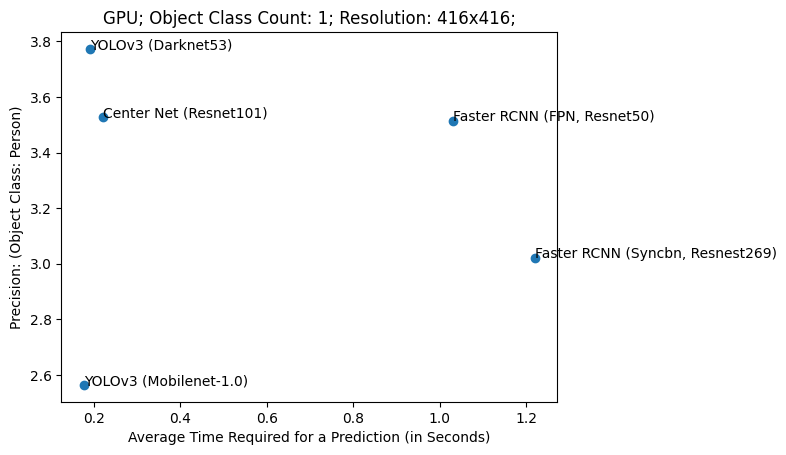

In [15]:
import matplotlib.pyplot as plt
import numpy as np


y = [2.56422, 3.77284, 3.52623, 3.51468, 3.02199]
z = [0.1765, 0.1912, 0.2204, 1.0317, 1.22]

n = ['YOLOv3 (Mobilenet-1.0)', 
     'YOLOv3 (Darknet53)',
     'Center Net (Resnet101)',
     'Faster RCNN (FPN, Resnet50)',
     'Faster RCNN (Syncbn, Resnest269)']

fix, ax = plt.subplots()
ax.scatter(z, y)

plt.title("GPU; Object Class Count: 1; Resolution: 416x416;")
plt.ylabel("Precision: (Object Class: Person)")
plt.xlabel("Average Time Required for a Prediction (in Seconds)")


for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))
    
plt.show()

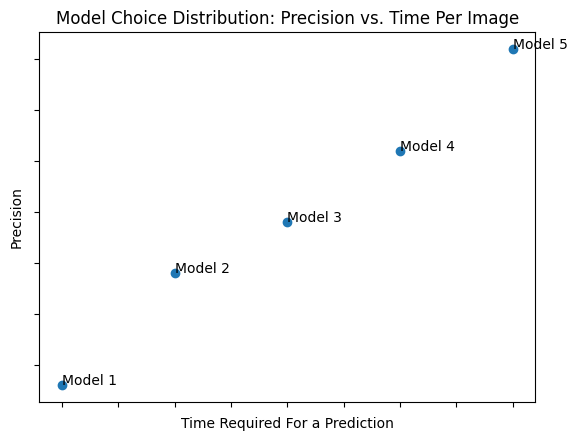

In [5]:
import matplotlib.pyplot as plt
import numpy as np



y = [.33, .44, .49, .56, .66]
z = [0.2, 0.3, 0.4, .5, .6]

n = ['Model 1', 
     'Model 2',
     'Model 3',
     'Model 4',
     'Model 5']

fix, ax = plt.subplots()
ax.scatter(z, y)

plt.title("Model Choice Distribution: Precision vs. Time Per Image")
plt.ylabel("Precision")
plt.xlabel("Time Required For a Prediction")


for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

ax.set_yticklabels([])
ax.set_xticklabels([])

    
plt.show()